# Chapter 3 - Text and Speech Basics
Let's start by downloading and loading the data.

In [399]:
!git clone https://github.com/johncliu/reuters-21578-json.git

import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
  
filelist = ['reuters-000.json',
            'reuters-001.json',
            'reuters-002.json',
            'reuters-003.json',
            'reuters-004.json',
            'reuters-005.json',
            'reuters-006.json',
            'reuters-007.json',
            'reuters-008.json',
            'reuters-009.json',
            'reuters-010.json',
            'reuters-011.json',
            'reuters-012.json',
            'reuters-013.json',
            'reuters-014.json',
            'reuters-015.json',
            'reuters-016.json',
            'reuters-017.json',
            'reuters-018.json',
            'reuters-019.json',
            'reuters-020.json',
            'reuters-021.json']
data_set = pd.DataFrame()
for fname in filelist:
  df = pd.read_json('reuters-21578-json/'+fname).T
  data_set = data_set.append(df)
  
data_set = data_set.fillna('')
print("Done!")         

fatal: destination path 'reuters-21578-json' already exists and is not an empty directory.
Done!


# **Exploratory Data Analysis**

Our first task is to take a close look at the dataset by loading and performing ex-ploratory data analysis. To do so, we must extracting metadata and the text bodyfrom each document in the corpus. If we take a close look at the corpus, we find some interesting facts. Run the next three cells to visualize the results.

documents with at least one topic =  11367
max number of topics in one document =  16
topics =  120
places =  147
organizations =  32


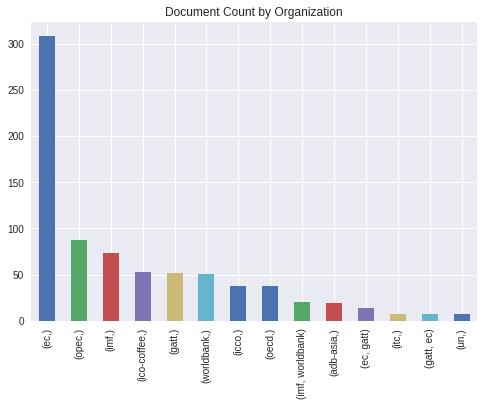

In [273]:
topics = set([x for sublist in data_set[u'topics'].values.tolist() for x in sublist])
places = set([x for sublist in data_set[u'places'].values.tolist() for x in sublist])
orgs = set([x for sublist in data_set[u'organisations'].values.tolist() for x in sublist])

data_set['topic_count']=data_set[u'topics'].apply(lambda x:len([y for y in x]))
print("documents with at least one topic = ",len(data_set[data_set[u'topic_count']>0]))
print("max number of topics in one document = ",data_set[u'topic_count'].max())
print('topics = ',len(topics))
print('places = ',len(places))
print('organizations = ',len(orgs))

data_set[u'organisations'].apply(tuple).value_counts()[1:15].plot(kind='bar',title="Document Count by Organization")



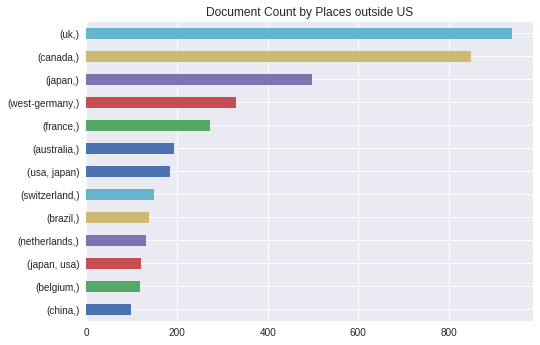

In [274]:
data_set[u'places'].apply(tuple).value_counts()[2:15].sort_values().plot(kind='barh',title='Document Count by Places outside US')

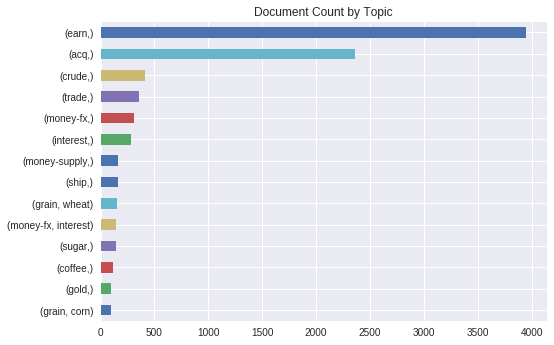

In [275]:
data_set[u'topics'].apply(tuple).value_counts()[1:15].sort_values().plot(kind='barh',title='Document Count by Topic')

So far so good. But before we perform any NLP analysis, we will want to perform some text normalization:

*   transform to lower case
*   remove punctuation & numbers
*   stem verbs
*   remove stopwords

To do so, we define a SimpleTokenizer method that will be useful when creating document representations. For our analysis, we will analyze documents involving five topics (crude, trade, money-fx, coffee, and gold).


In [276]:
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing.label import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("punkt")
nltk.download("stopwords","data")
nltk.data.path.append('data')

labelBinarizer = MultiLabelBinarizer()
data_target = labelBinarizer.fit_transform(data_set[u'topics'])

stopWords = stopwords.words('english')
charfilter = re.compile('[a-zA-Z]+');

def SimpleTokenizer(text):
  words = map(lambda word: word.lower(), word_tokenize(text))
  words = [word for word in words if word not in stopWords]
  tokens = (list(map(lambda token: PorterStemmer().stem(token),words)))
  ntokens = list(filter(lambda token:charfilter.match(token),tokens))
  return ntokens

vec = TfidfVectorizer(tokenizer=SimpleTokenizer,
                        max_features=1000,
                        norm='l2')


mytopics = [u'cocoa',u'trade',u'money-supply',u'coffee',u'gold']
data_set = data_set[data_set[u'topics'].map(set(mytopics).intersection).apply( lambda x: len(x)>0 )]
docs = list(data_set[u'body'].values)

dtm = vec.fit_transform(docs)

print("Number of documents with my topics = ",len(data_set))

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Number of documents with my topics =  1076


# **Text Clustering**

We want to see if clusters exist in the documents, so let’s create some document representations through TFIDF. This gives us a document term matrix, but typically the dimensions of this matrix is too large and the representations are sparse. Let's first apply Principal Component Analysis (PCA) to reduce the dimensionality. The original TFIDF vectors have dimension = 1000. Let's take a look at the effect of dimensionality reduction by plotting the proportion of explained variance of the data as a function of the number of principal components:

Text(0,0.5,'Proportion of Explained Variance')

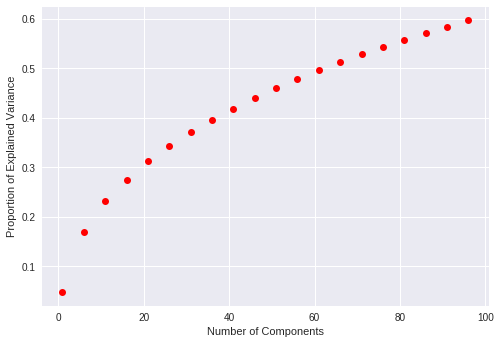

In [277]:
from sklearn.decomposition import PCA

explained_var = []
for components in range(1,100,5):
  pca = PCA(n_components=components)
  pca.fit(dtm.toarray())
  explained_var.append(pca.explained_variance_ratio_.sum())

plt.plot(range(1,100,5),explained_var,"ro")
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Explained Variance")

The graph above shows that half of the variance an be explained by 60 components. Let's apply this to the dataset, and visualize the results by plotting the first two PCA components of each document:

Explained variance of the PCA step: 49%


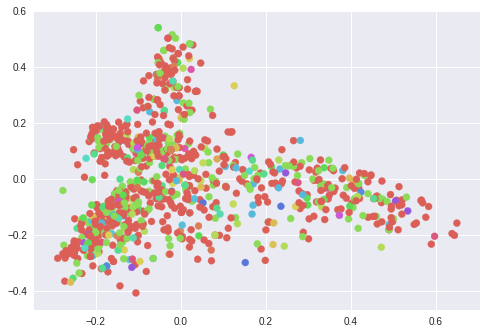

In [278]:
from sklearn.decomposition import PCA
import seaborn as sns

components = 60

palette = np.array(sns.color_palette("hls", 120))

pca = PCA(n_components=components)
pca.fit(dtm.toarray())
pca_dtm = pca.transform(dtm.toarray())

plt.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[data_target.argmax(axis=1).astype(int)])

explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(
    int(explained_variance * 100)))

We know that there are 5 distinct topics (though some documents might have overlap), so let’s run the k-means algorithm with k=5 to examine document grouping:

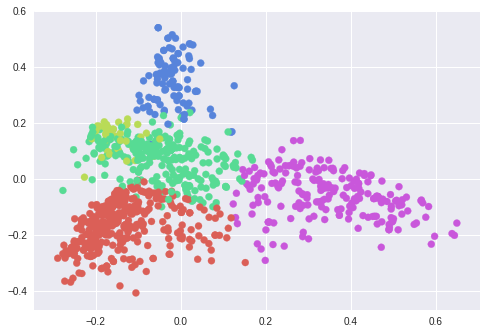

In [279]:
from sklearn.cluster import KMeans
palette = np.array(sns.color_palette("hls", 5))

model = KMeans(n_clusters=5,max_iter=100)
clustered = model.fit(pca_dtm)
centroids = model.cluster_centers_
y = model.predict(pca_dtm)

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[y.astype(np.int)])

Even with only capturing 50% of the variance, the clustering is fairly good when we compare with the manual (gold) labels.

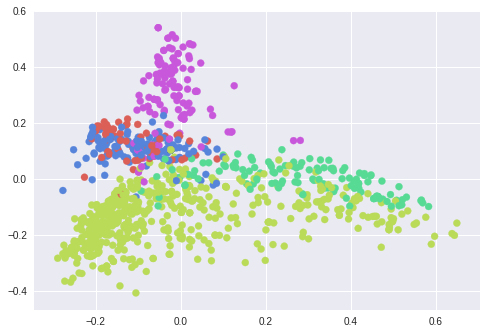

In [280]:
palette = np.array(sns.color_palette("hls", 5))

gold_labels = data_set['topics'].map(set(mytopics).intersection).apply(lambda x: x.pop()).apply(lambda x: mytopics.index(x))

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[gold_labels])

Feel free to change the number of PCA components and see how well k-means performs vs. the gold labels. 

# **Topic Modeling**

In addition to the lexical clustering of documents, lets see if we can discern any natural topic structure within the corpus. We apply the LSA and LDA algorithms, which will associate words to a set of topics, and topics to our set of documents.

##LSA
We start with the LSA algorithm, and set the number of dimensions to 60:

Explained variance of the SVD step: 49%


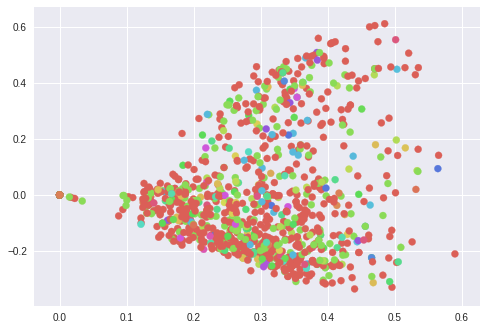

In [281]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

components = 60

palette = np.array(sns.color_palette("hls", 120))

lsa = TruncatedSVD(n_components=components)
lsa.fit(dtm)
lsa_dtm = lsa.transform(dtm)

plt.scatter(lsa_dtm[:,0],lsa_dtm[:,1],c=palette[data_target.argmax(axis=1).astype(int)])

explained_variance = lsa.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))


As with PCA, let's apply k-means with k = 5 clusters:

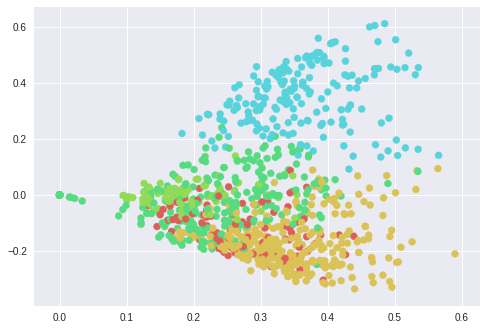

In [282]:
from sklearn.cluster import KMeans
palette = np.array(sns.color_palette("hls", 8))

model = KMeans(n_clusters=5,max_iter=100)
clustered = model.fit(lsa_dtm)
centroids = model.cluster_centers_
y = model.predict(lsa_dtm)

ax = plt.subplot()
sc = ax.scatter(lsa_dtm[:,0],lsa_dtm[:,1],c=palette[y.astype(np.int)])

Let's examine the documents of one of these clusters:

In [283]:
topic = u'coffee'

data_set[gold_labels == mytopics.index(topic)][u'body'].head(10)

232    Talks on the possibility of reintroducing\nglo...
235    Indonesia"s agriculture sector will grow\nby j...
249    The International Coffee Organization\n(ICO ) ...
290    Talks on coffee export quotas at the\nInternat...
402    Coffee quota talks at the International\nCoffe...
42     International Coffee Organization, ICO,\nprodu...
562    Talks at the extended special meeting of\nthe ...
75     International Coffee Organization (ICO)\nexpor...
754    Efforts to break an impasse between\ncoffee ex...
842    A special meeting of the International\nCoffee...
Name: body, dtype: object

Let's see if the LDA algorithm can do better as a Bayesian as a Bayesian approach to document clustering and topic modeling. We set the number of topics to the known number of topics = 5.

In [284]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns

components = 5
n_top_words = 10

palette = np.array(sns.color_palette("hls", 120))
    
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
  
lda = LatentDirichletAllocation(n_components=components,max_iter=5,learning_method='online')
lda.fit(dtm)
lda_dtm = lda.transform(dtm)

vec_feature_names = vec.get_feature_names()
print_top_words(lda, vec_feature_names, n_top_words)


Topic #0: said trade u.s. deleg quota brazil export year coffe market
Topic #1: gold mine ounc ton said ltd compani ore feet miner
Topic #2: fed volcker reserv treasuri bank borrow pct rate growth dlr
Topic #3: said trade u.s. export japan coffe would ec market offici
Topic #4: billion dlr mln pct januari februari rose bank fell year



The LDA results are encouraging, and we can easily discern 4 of the 5 original topics from the list of words associated with each topic.

# Document Classification
Now let's see if we can build classifiers to possibly identify the topics above. We first randomize and split our dataset into train and test sets.

In [357]:
from sklearn.model_selection import train_test_split

data_set['label'] = gold_labels

X_train, X_test, y_train, y_test = train_test_split(data_set,gold_labels,test_size=0.2, random_state=10)
print("Train Set = ",len(X_train))
print("Test Set  = ",len(X_test))

X_train = X_train[u'body']
X_test = X_test[u'body']


Train Set =  860
Test Set  =  216


When then create a pipeline that builds classifiers based on 5 models: Naive Bayes, Logistic Regression, SVM,K-Nearest Neighbor, and Random Forest.

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

models = [('multinomial_nb', MultinomialNB()),
          ('log_reg', LogisticRegression()),
          ('linear_svc', LinearSVC()),
          ('knn', KNeighborsClassifier(n_neighbors=6)),
          ('rf', RandomForestClassifier(n_estimators=6))]


We then train each model on the training set and evaluate on the test set. For each model, we want to see the precision, recall, F1 score, and support (number of samples) for each topic class.

In [389]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

for m_name, model in models:
    pipeline = Pipeline([('vec', TfidfVectorizer(tokenizer=SimpleTokenizer)),(m_name,model)])
    pipeline.fit(X_train,y_train)
    test_y = pipeline.predict(X_test)
    print("model = ",model,"\n")
    print(classification_report(y_test,test_y,digits=6))


model =  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

             precision    recall  f1-score   support

          0   1.000000  0.384615  0.555556        13
          1   0.658683  1.000000  0.794224       110
          2   1.000000  0.297872  0.459016        47
          3   1.000000  0.526316  0.689655        19
          4   1.000000  0.740741  0.851064        27

avg / total   0.826181  0.736111  0.704828       216

model =  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

             precision    recall  f1-score   support

          0   0.888889  0.615385  0.727273        13
          1   0.802920  1.000000  0.890688       110
          2   1.000000  0.553191  0.712329        47
          3   1.000000  0.947368  0.972973        19
          4   

The results seem to indicate that a linear SVM model seems to perform the best, with Random Forest a close second. This is a bit misleading, since we didn't tune any of these models to obtain our results. Hyperparameter tuning can significantly affect how well a classifier performs. Let's try tuning the LinearSVC model. The tuneable parameters are:

In [395]:
vectorizer = TfidfVectorizer(tokenizer=SimpleTokenizer)
model = LinearSVC()
print("vec params = ",vectorizer.get_params().keys())
print("model params = ",model.get_params().keys())

vec params =  dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])
model params =  dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])


We want to tune these parameters by using grid search with cross-validation. Note that cross-validation is important as we do not want to tune with our test set, which we will use only at the end to assess performance. Note also that this can take a while!

In [396]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([('vec', vectorizer),
                     ('model', model)])

parameters = {'vec__ngram_range': ((1, 1), (1, 2)),
              'vec__max_features': (500, 1000),
              'model__loss': ('hinge', 'squared_hinge'),
              'model__C': (1, 0.9)}

grid_search = GridSearchCV(pipeline, parameters,verbose=1)
grid_search.fit(X_train, y_train)

test_y = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test,test_y,digits=6))


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  4.8min finished


             precision    recall  f1-score   support

          0   0.909091  0.769231  0.833333        13
          1   0.980769  0.927273  0.953271       110
          2   0.836364  0.978723  0.901961        47
          3   0.947368  0.947368  0.947368        19
          4   1.000000  1.000000  1.000000        27

avg / total   0.944499  0.939815  0.940210       216



As you see, the SVM model typically outperforms other machine learning algorithms, and often provides as the state-of-the-art in quality. Unfortunately, SVM suffers from several major drawbacks, including the inability to scale to large datasets. As we will learn in later chapters, neural networks can bypass the limitations of SVMs.